## Initial data analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import remove_outliers

# Path to the data
data_path = "./data/ClimateTrain.csv"

# Read as pandas dataframe and transform dates to datetime
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Plot description
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


## raw data

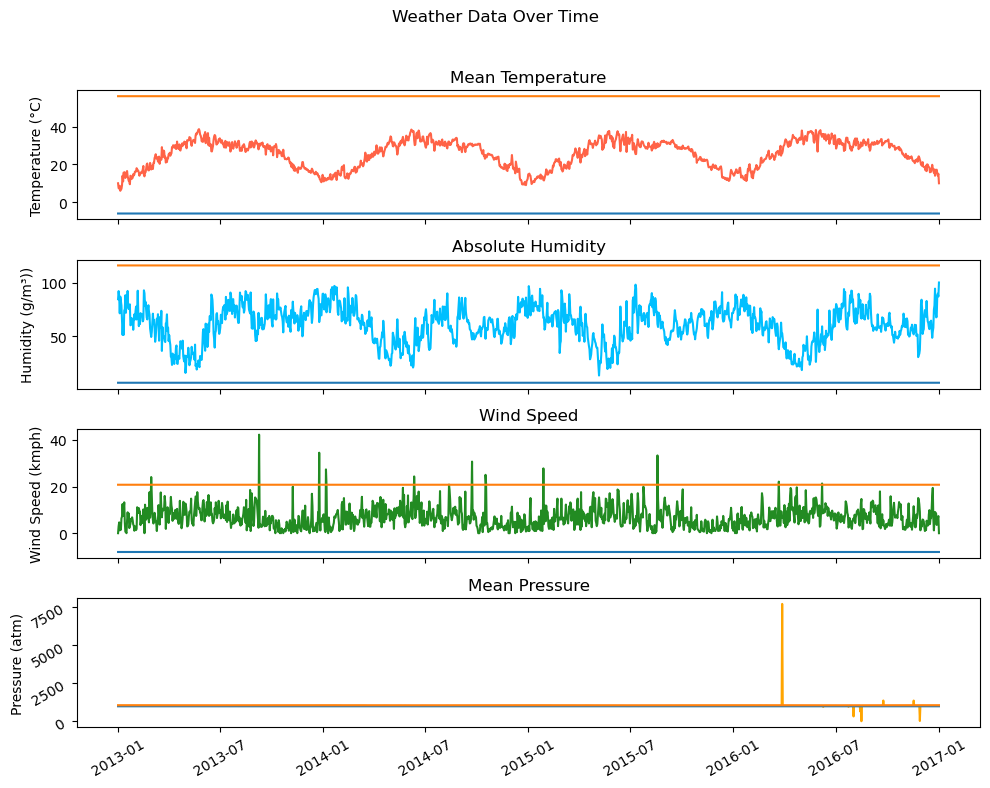

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)  # 4 rows, 1 column
fig.suptitle("Weather Data Over Time")
titles = ["Mean Temperature", "Absolute Humidity", "Wind Speed", "Mean Pressure"]
ylabels = ["Temperature (°C)", "Humidity (g/m³))", "Wind Speed (kmph)", "Pressure (atm)"]
colors = ["tomato", "deepskyblue", "forestgreen", "orange"]

for idx, var in enumerate(df.columns):
    
    axes[idx].plot( df[var], color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx])
    axes[idx].set_title(titles[idx])
    
    #* Optional 
    _, fence_low, fence_high = remove_outliers(df, var)
    axes[idx].plot(df.index, len(df[var])*[fence_low])
    axes[idx].plot(df.index, len(df[var])*[fence_high])

# Set x-axis major ticks to show selective dates only
axes[3].tick_params(rotation=30)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to accommodate suptitle
plt.show()

# Plot cleaned data

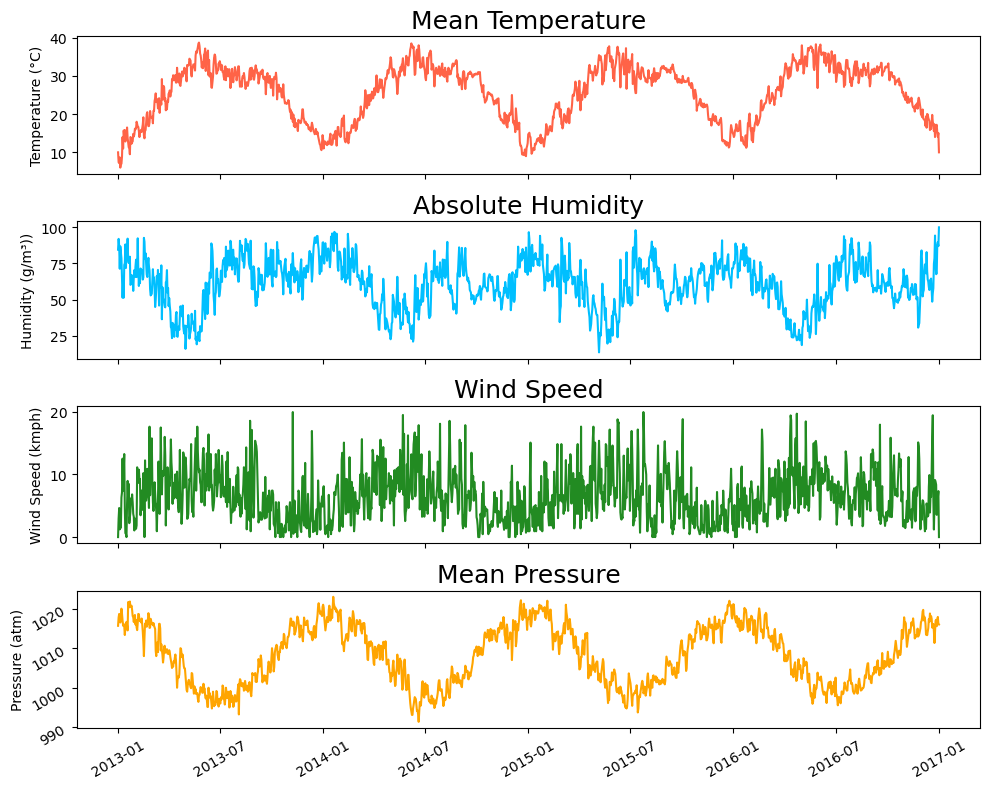

In [36]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)  # 4 rows, 1 column


for var in df.columns:
    df, fence_low, fence_high = remove_outliers(df, var)
    
for idx, var in enumerate(df.columns):
    
    axes[idx].plot( df[var], color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=10)
    axes[idx].set_title(titles[idx], fontsize=18)

# Set x-axis major ticks to show selective dates only
axes[3].tick_params(rotation=30, labelsize=10)

plt.tight_layout()
plt.savefig(f"./images/cleaned_data.pdf", format="pdf")
plt.show()

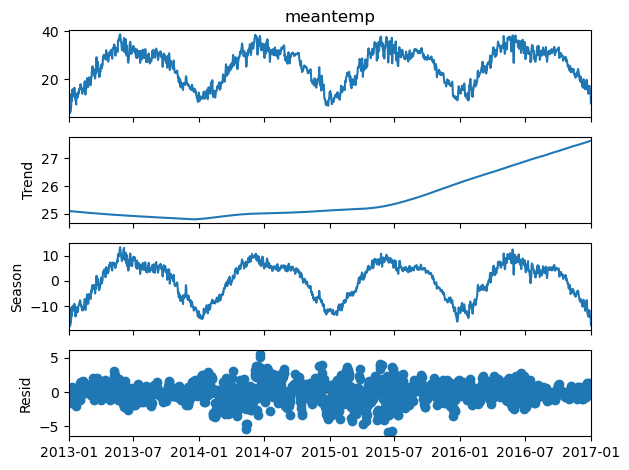

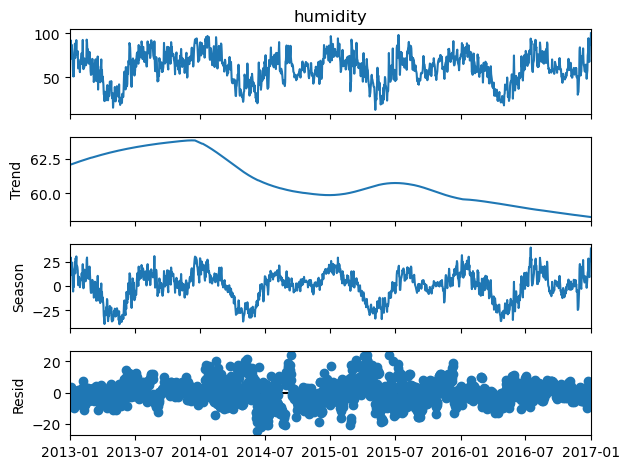

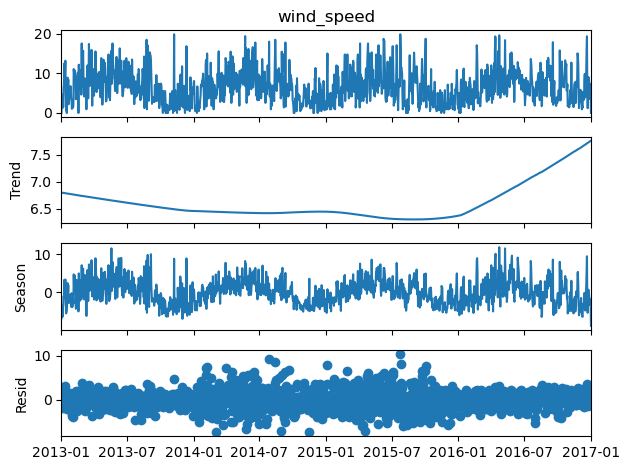

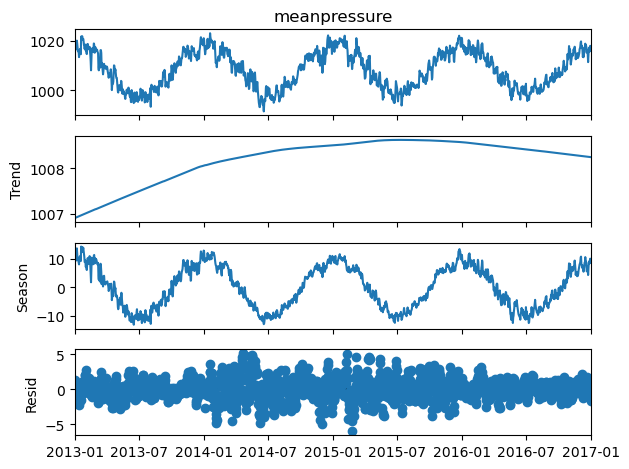

In [21]:
from statsmodels.tsa.seasonal import STL


for var in df.columns:
    # Select the variable you want to apply STL to
    series = df[var]

    # Apply STL decomposition
    period = 365  # Adjust based on your data's frequency and seasonality

    # Apply STL decomposition with the specified period
    stl = STL(series, period=period, seasonal=7)  # Adjust seasonal as needed
    res = stl.fit()

    # Plot the results
    fig = res.plot()
    plt.show()